<a href="https://colab.research.google.com/github/leonyi/zero-to-mlai-mastery/blob/main/capstone-stock-market-prediction/stock_prediction_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stock market prediction

This notebook provides the initial analysis using various libraries in an attempt to train a machine learning model capable of predicting the stock price for a give stock using the principals of Financial Engineering.


In [ ]:
# Ensure the yfinance python library is loaded. This doesn't require an API key so it's easy to use for the purposes of our initial analysis.
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas_datareader
import pandas_datareader.data as pdr
import datetime
import yfinance as yf
import os

from glob import glob
from keras.preprocessing.sequence import TimeseriesGenerator
from scipy.stats import probplot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras import regularizers
from plotly import graph_objects as go
from pandas import set_option
from pandas.plotting import scatter_matrix
from numpy import arange

%matplotlib inline

# Problem Definition
In a statement,

> Given the characteristics and historical data trends for a given company stock, can we reliably predict the value of their stock?

# Data

The data is retreived from Yahoo for the SP500 companies. The list of companies came from [Kaggle](https://www.kaggle.com/camnugent/sandp500). The dataset is a little outdated but will be good as an initial step to understand the financial data we will be dealing with. Later, we can recreate the dataset downloading recent financial data for all sp500 companies and filter just a handful (100 or so), which always includes those ones we may be interested to keep an eye on (e.g. NFLX, AAPL, TSLA, etc.).

# Features
The data we will analyze are time series that are sampled at equally spaced intervals. The data contains the following features:

*   volume - total number of shares that were traded during that time period.Traded means that the stocks were sold by someone and bought by someone else.
*   open, high, low and close - give us information about how the stock price changed during the block of time:
    - open: the price at the beginning of the period.
    - high: the maximum price during that period.
    - low: the minimum price during that period.
    - close: the price at the end of the period.
* date - in format: yy-mm-dd 
* name - stock's ticker name
* adjusted close - 

In the stock market a transaction to purchase a stock is more like an auction than a direct sale and they are performed via an order book through an event called an order. Any transaction requires someone willing to buy at a price at or above the requested price; so, this is not a guranteed transaction. The exchange collects the orders and matches them for execution. 





## Fetch the Data
We will create a set of 100 companies' stock symbol, combining the ones I selected and some from the wider selection of the SPS500 dataset from Kaggle.

In [ ]:
# Set the location of the data as a "global" variable
data_dir = '/content/drive/MyDrive/Colab Notebooks/data'

## Load the Data
The type of data we will be analysing is stock price and volume.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/all_stocks_5yr.csv')


## Understand the Data

In [ ]:
# Data Description
# Let's take a look at the summary of each attribute. The output inclues, the mean, the min, max, count values and percentile info.
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [ ]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


**OBSERVATION:** The way the data is laid out at the moment is by date entry per stock symbol. This needs to be re-constructed with a single day entry per stock.

In [ ]:
# Get the names of all the stock symbols in the dataset.
df['Name'].unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

In [ ]:
# Sanity check to see that we have the expected # of entries (~500)
df['Name'].unique().shape

(505,)

In [ ]:
# Checking the stock of Netflix, just to see the entries.
df[df['Name'] == 'NFLX']

,date,open,high,low,close,volume,Name
407525,2013-02-08,25.9635,26.2800,25.7157,25.8528,25649820,NFLX
407526,2013-02-11,25.5685,26.0071,24.9714,25.4128,29321782,NFLX
407527,2013-02-12,25.8085,26.2228,25.1014,25.4214,34388802,NFLX
407528,2013-02-13,25.8428,26.6285,25.6657,26.6098,40799094,NFLX
407529,2013-02-14,26.7557,27.1214,26.3844,26.7714,31968685,NFLX
...,...,...,...,...,...,...,...
408779,2018-02-01,266.4100,271.9500,263.3800,265.0700,9669011,NFLX
408780,2018-02-02,263.0000,270.6200,262.7100,267.4300,9123610,NFLX
408781,2018-02-05,262.0000,267.8990,250.0300,254.2600,11896053,NFLX
408782,2018-02-06,247.7000,266.7000,245.0000,265.7200,12595801,NFLX


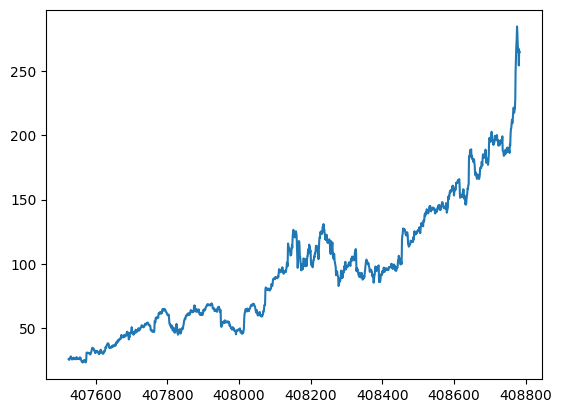

In [ ]:
# Let's plot whath the closing entries look like for NFLX.
nflx = df[df['Name'] == 'NFLX']
nflx['close'].plot();

**Observation:** Closing prices for this particular stock increase steadily for this time period.

In [ ]:
# Check the time period included in the dataset.
df['date'].min(), df['date'].max()

('2013-02-08', '2018-02-07')

**OBSERVATION:** Definitely an outdated dataset for accurate current predictions but good to become familiar with the data we will be working with. In its current state the data is separate for each stock, so let's use the dates (common entry on all observations) to organize the data.

In [ ]:
dates = pd.date_range(df['date'].min(), df['date'].max())
dates

DatetimeIndex(['2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11',
               '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15',
               '2013-02-16', '2013-02-17',
               ...
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07'],
              dtype='datetime64[ns]', length=1826, freq='D')

In [ ]:
# In the Finance industry is best practice to work with the closing dates; so, let's take a look at these trends. 
# Note the freq entry on the output of the dates dataframe, it tells us that each value in the index was captured daily on a different day.
close_prices = pd.DataFrame(index=dates)

**OBSERVATION:** Let's setup a dataframe containing the closing dates as the index and the columns for each of the stock symbols. Each date entry (row) will list the closing price for that stock on the specified closing date.

In [ ]:
close_prices.head()

""
2013-02-08
2013-02-09
2013-02-10
2013-02-11
2013-02-12


In [ ]:
# Now let's capture the symbols
symbols = df['Name'].unique()
print(symbols)

['AAL' 'AAPL' 'AAP' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADSK' 'ADS' 'AEE' 'AEP' 'AES' 'AET' 'AFL' 'AGN' 'AIG' 'AIV' 'AIZ' 'AJG'
 'AKAM' 'ALB' 'ALGN' 'ALK' 'ALLE' 'ALL' 'ALXN' 'AMAT' 'AMD' 'AME' 'AMGN'
 'AMG' 'AMP' 'AMT' 'AMZN' 'ANDV' 'ANSS' 'ANTM' 'AON' 'AOS' 'APA' 'APC'
 'APD' 'APH' 'APTV' 'ARE' 'ARNC' 'ATVI' 'AVB' 'AVGO' 'AVY' 'AWK' 'AXP'
 'AYI' 'AZO' 'A' 'BAC' 'BAX' 'BA' 'BBT' 'BBY' 'BDX' 'BEN' 'BF.B' 'BHF'
 'BHGE' 'BIIB' 'BK' 'BLK' 'BLL' 'BMY' 'BRK.B' 'BSX' 'BWA' 'BXP' 'CAG'
 'CAH' 'CAT' 'CA' 'CBG' 'CBOE' 'CBS' 'CB' 'CCI' 'CCL' 'CDNS' 'CELG' 'CERN'
 'CFG' 'CF' 'CHD' 'CHK' 'CHRW' 'CHTR' 'CINF' 'CI' 'CLX' 'CL' 'CMA' 'CMCSA'
 'CME' 'CMG' 'CMI' 'CMS' 'CNC' 'CNP' 'COF' 'COG' 'COL' 'COO' 'COP' 'COST'
 'COTY' 'CPB' 'CRM' 'CSCO' 'CSRA' 'CSX' 'CTAS' 'CTL' 'CTSH' 'CTXS' 'CVS'
 'CVX' 'CXO' 'C' 'DAL' 'DE' 'DFS' 'DGX' 'DG' 'DHI' 'DHR' 'DISCA' 'DISCK'
 'DISH' 'DIS' 'DLR' 'DLTR' 'DOV' 'DPS' 'DRE' 'DRI' 'DTE' 'DUK' 'DVA' 'DVN'
 'DWDP' 'DXC' 'D' 'EA' 'EBAY' 'ECL' 'ED' 'EFX' 'EIX' 'E

In [ ]:
# Declare an empty dataframe to run a test to append each observation as a date entry per stock symbol.
close_prices_test = pd.DataFrame()

In [ ]:
# Ensuring that all the data is set as expected. I am using the Netflix stock to validate that we can re-arrange the dataframe with entries by date for each stock symbol.
df_test = pd.DataFrame(data=nflx['close'].to_numpy(), index=nflx['date'], \
                   columns=['NFLX'])

# Ensuring the index in the new dataframe is of type date.
close_prices_test = pd.DataFrame(index=dates)
df_test.index = pd.to_datetime(df_test.index)

close_prices_test = close_prices_test.join(df_test, how='left')
close_prices_test.head()

,NFLX
2013-02-08,25.8528
2013-02-09,NaN
2013-02-10,NaN
2013-02-11,25.4128
2013-02-12,25.4214


**OBSERVATION:** Looks like the append to a new close prices data frame will work. We will have each observation entered as a date for each of the stock symbos as columns.

In [ ]:
# Populate the dataframe
for symbol in symbols:
  print(f'creating dataframe for {symbol}')
  symbol_df = df[df['Name'] == symbol]
  tmp_df = pd.DataFrame(data=symbol_df['close'].to_numpy(), index=symbol_df['date'], columns=[symbol])

  # Ensure index on tmp_df is of type date.
  tmp_df.index = pd.to_datetime(tmp_df.index)

  # Append the stock symbol dataframe into the close prices df. Both indexes are of type date now.
  close_prices = close_prices.join(tmp_df, how='left')

creating dataframe for AAL
creating dataframe for AAPL
creating dataframe for AAP
creating dataframe for ABBV
creating dataframe for ABC
creating dataframe for ABT
creating dataframe for ACN
creating dataframe for ADBE
creating dataframe for ADI
creating dataframe for ADM
creating dataframe for ADP
creating dataframe for ADSK
creating dataframe for ADS
creating dataframe for AEE
creating dataframe for AEP
creating dataframe for AES
creating dataframe for AET
creating dataframe for AFL
creating dataframe for AGN
creating dataframe for AIG
creating dataframe for AIV
creating dataframe for AIZ
creating dataframe for AJG
creating dataframe for AKAM
creating dataframe for ALB
creating dataframe for ALGN
creating dataframe for ALK
creating dataframe for ALLE
creating dataframe for ALL
creating dataframe for ALXN
creating dataframe for AMAT
creating dataframe for AMD
creating dataframe for AME
creating dataframe for AMGN
creating dataframe for AMG
creating dataframe for AMP
creating dataframe

In [ ]:
# Let's take a look at the entries for the re-arranged "new" dataframe.
close_prices.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74


**OBSERVATION:** It looks like our dataframe has empty rows - we will need to get rid of those as we progress in the data sanitation phase.

In [ ]:
# Another validation using our sample stock.
close_prices['NFLX']

2013-02-08     25.8528
2013-02-09         NaN
2013-02-10         NaN
2013-02-11     25.4128
2013-02-12     25.4214
                ...   
2018-02-03         NaN
2018-02-04         NaN
2018-02-05    254.2600
2018-02-06    265.7200
2018-02-07    264.5600
Freq: D, Name: NFLX, Length: 1826, dtype: float64

**OBSERVATION:** We have a lot of missing values. This is because of the way we constructed the date index with a date range. Not all of those dates would have been a trading date. Per internet souces there are usually 252 trading days per year and there is no trading on the weekends.

In [ ]:
# What is the total number of missing values in the entire close_prices dataframe?
close_prices.isnull().sum().sum()

303090

**OBSERVATION:** Interesting doing a single .sum() revealed that each column had a total count of 567 missing entries. Could those just be weekend entries? 

In [ ]:
# Lists the details of the close_prices dataframe.
close_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-02-08 to 2018-02-07
Freq: D
Columns: 505 entries, AAL to ZTS
dtypes: float64(505)
memory usage: 7.1 MB


In [ ]:
# Saves the new dataframe as a csv file.
close_prices.to_csv(f'{data_dir}/sp500_close.csv')

In [ ]:
# Let's look at the entries for sanity
!head "/content/drive/MyDrive/Colab Notebooks/data/sp500_close.csv"

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,ADS,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALLE,ALL,ALXN,AMAT,AMD,AME,AMGN,AMG,AMP,AMT,AMZN,ANDV,ANSS,ANTM,AON,AOS,APA,APC,APD,APH,APTV,ARE,ARNC,ATVI,AVB,AVGO,AVY,AWK,AXP,AYI,AZO,A,BAC,BAX,BA,BBT,BBY,BDX,BEN,BF.B,BHF,BHGE,BIIB,BK,BLK,BLL,BMY,BRK.B,BSX,BWA,BXP,CAG,CAH,CAT,CA,CBG,CBOE,CBS,CB,CCI,CCL,CDNS,CELG,CERN,CFG,CF,CHD,CHK,CHRW,CHTR,CINF,CI,CLX,CL,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COG,COL,COO,COP,COST,COTY,CPB,CRM,CSCO,CSRA,CSX,CTAS,CTL,CTSH,CTXS,CVS,CVX,CXO,C,DAL,DE,DFS,DGX,DG,DHI,DHR,DISCA,DISCK,DISH,DIS,DLR,DLTR,DOV,DPS,DRE,DRI,DTE,DUK,DVA,DVN,DWDP,DXC,D,EA,EBAY,ECL,ED,EFX,EIX,EL,EMN,EMR,EOG,EQIX,EQR,EQT,ESRX,ESS,ES,ETFC,ETN,ETR,EVHC,EW,EXC,EXPD,EXPE,EXR,FAST,FBHS,FB,FCX,FDX,FE,FFIV,FISV,FIS,FITB,FLIR,FLR,FLS,FL,FMC,FOXA,FOX,FRT,FTI,FTV,F,GD,GE,GGP,GILD,GIS,GLW,GM,GOOGL,GOOG,GPC,GPN,GPS,GRMN,GS,GT,GWW,HAL,HAS,HBAN,HBI,HCA,HCN,HCP,HD,HES,HIG,HII,HLT,HOG,HOLX,HON,HPE,HPQ,HP,HRB,HRL,HRS,HSIC,HST,HSY,HUM,IBM

**OBSERVATION:** All NaN entries are displayed as empty.

In [ ]:
# Load the aforementioned csv into a dataframe for further analysis. 
# We set parse_dates to True because we want those entries to be treated as dates vs just strings.
df_close = pd.read_csv(f'{data_dir}/sp500_close.csv', index_col=0, parse_dates=True)
df_close.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74


## Handling Missing Data



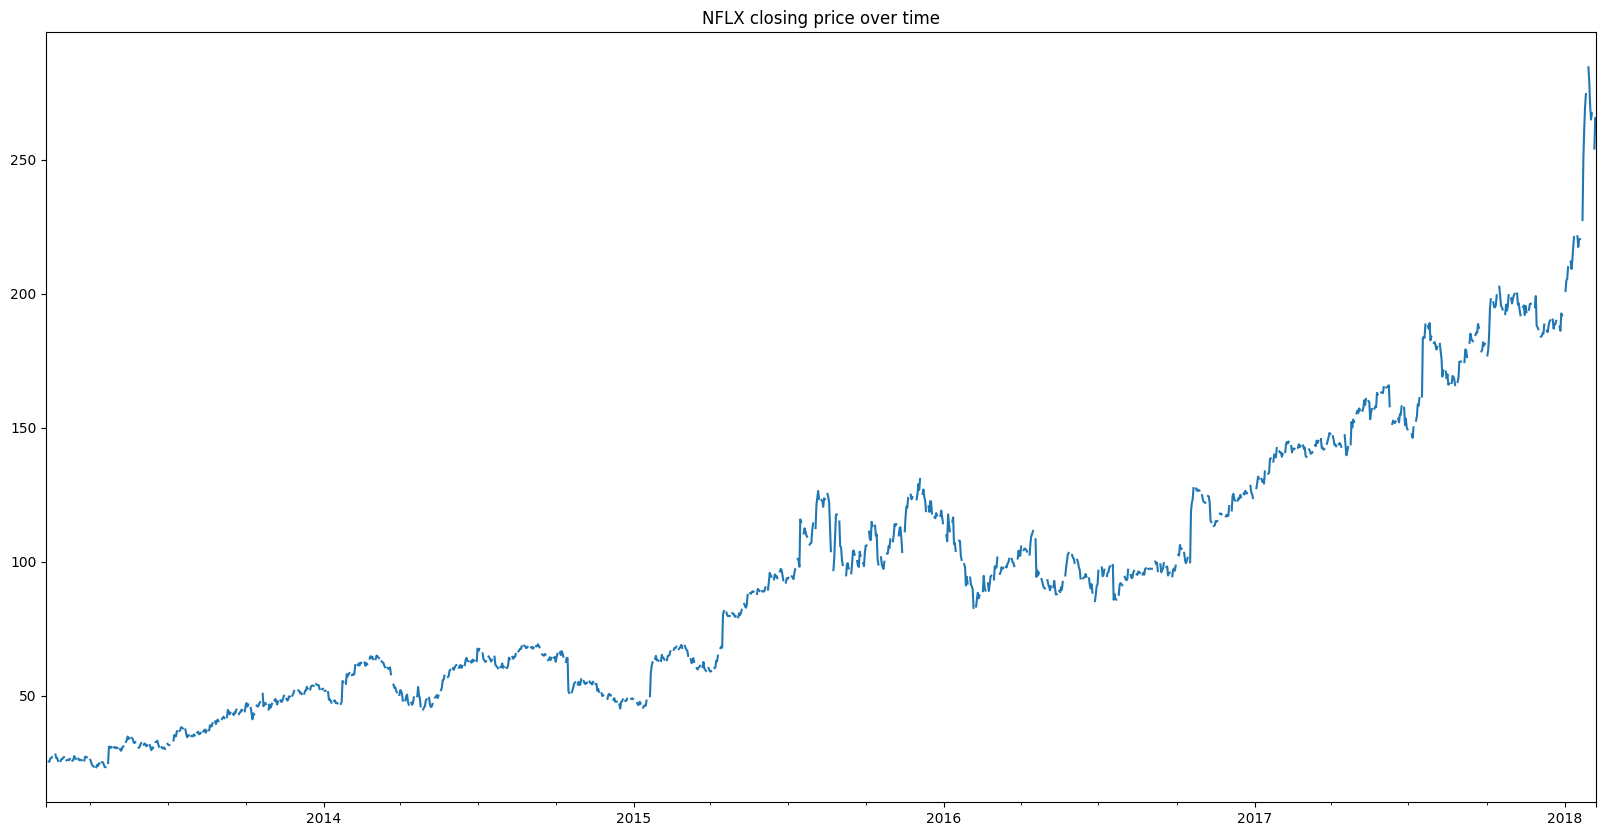

In [ ]:
# Now let's handle the missing data.
# Let's continue the exploration with the NFLX stock to see how the close price entries trend over time.
close_prices['NFLX'].plot(figsize=(20, 10), title="NFLX closing price over time");


In [ ]:
# Let's list the rows with missing data
null_data = close_prices[close_prices.isnull().any(axis=1)]
null_data

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Determine if null data happened on weekends
dates_day_of_week = {}
for d in null_data.index:
  dates_day_of_week[d] = d.weekday() # returns numerical value of the day of week.

dow = pd.DataFrame(dates_day_of_week, index=[0])
dow

,2013-02-08,2013-02-09,2013-02-10,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-16,2013-02-17,...,2018-01-07,2018-01-13,2018-01-14,2018-01-15,2018-01-20,2018-01-21,2018-01-27,2018-01-28,2018-02-03,2018-02-04
0,4,5,6,0,1,2,3,4,5,6,...,6,5,6,0,5,6,5,6,5,6


**OBSERVATION:** A quick look at the data indicates that the dates with null data were either weekends and likely holidays. If that assumption was wrong, nothing can be analyzed with missing entries. Deleting only those rows where **all** data is missing is the next step. 

In [ ]:
# Let's drop all those rows with Nan values on the dataframe we are working on (i.e. inplace)
close_prices.dropna(axis=0, how='all', inplace=True)

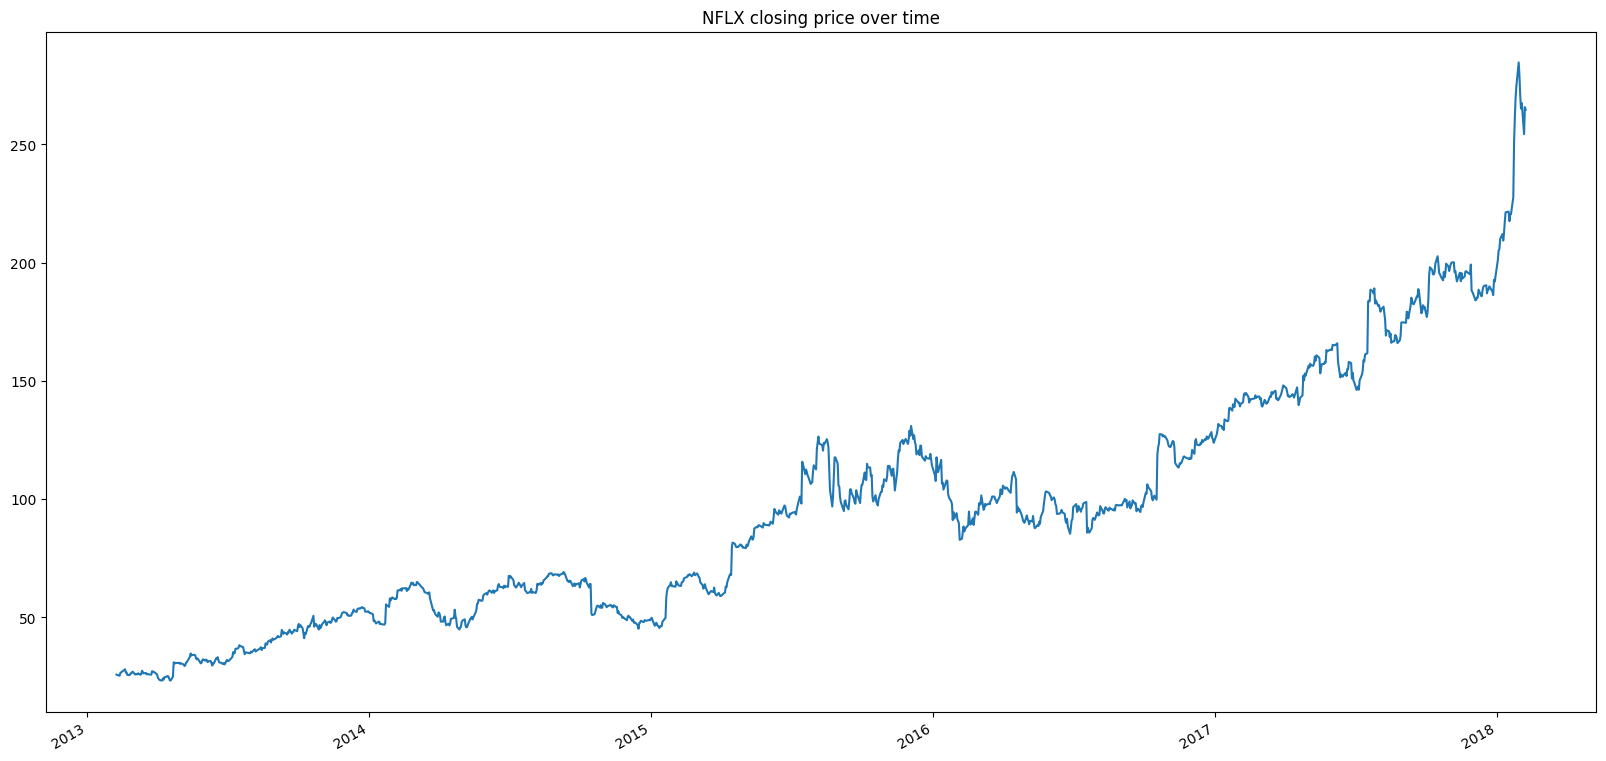

In [ ]:
# Let's visualize our previous stock (i.e. NFLX) trends
close_prices['NFLX'].plot(figsize=(20, 10), title="NFLX closing price over time");


**OBSERVATION:** The trends do look smoother.

In [ ]:
# Let's see what our sum of NaNs says now.
close_prices.isna().sum()

AAL     0
AAPL    0
AAP     0
ABBV    0
ABC     0
       ..
XYL     0
YUM     0
ZBH     0
ZION    0
ZTS     0
Length: 505, dtype: int64

In [ ]:
# Let's see what the sum accross the dataframe is now
close_prices.isnull().sum().sum()

16755

**OBSERVATION:** We may need to do some back/forward filling to fill-in the initial value of some stocks. Let's explore more.

In [ ]:
# How many stocks don't have an initial value? 
close_prices.iloc[0, :].isna().sum()

29

In [ ]:
# We got 29 stock symbols without an initial value... we can forward-fill to backward-fill those values.
close_prices.fillna(method='ffill', inplace=True)

In [ ]:
# How many missing values now?
close_prices.isna().sum().sum()

16704

In [ ]:
# The dataset (from Kaggle) is missing more data than expected. We will rerun exploration with an updated set.
# Let's now perform the backfill
close_prices.fillna(method='bfill', inplace=True)

In [ ]:
# # How many missing values now?
close_prices.isna().sum().sum()

0

<Axes: >

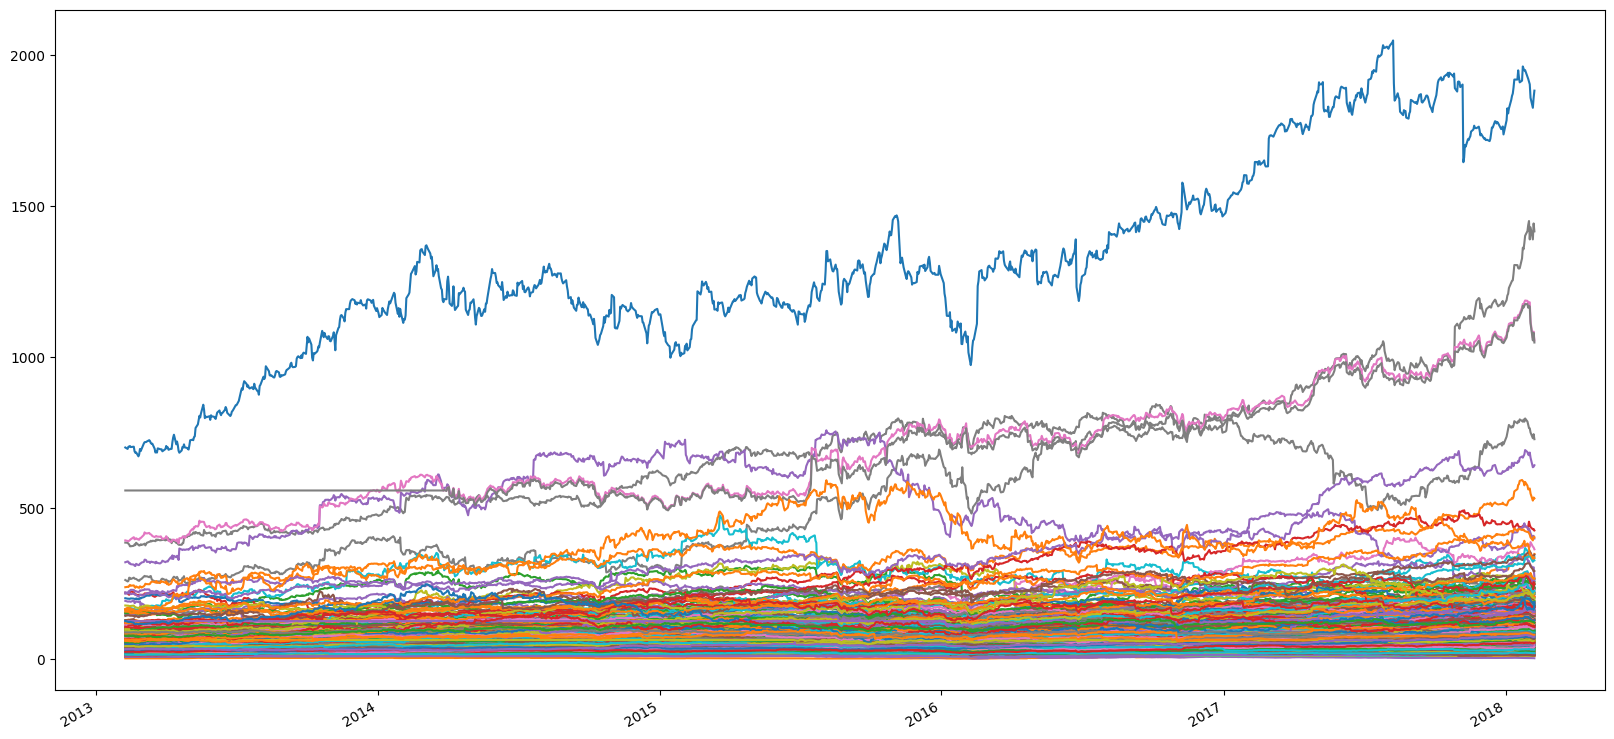

In [ ]:
# Let's visualize the stock trends
close_prices.plot(figsize=(20, 10), legend=False)


**OBSERVATION:** We can clearly see the backfilling in action with the horizontal line shown starting at coordinate ~(2013, 550), with a year worth of missing data for that particular stock.

**Plot the relative stock price over time.**

In [ ]:
# Let's divide each column of stocks by its initial value to observe the growth patterns of different stocks.
close_prices_normalized = close_prices/close_prices.iloc[0]
close_prices_normalized

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2013-02-11,0.980339,1.010422,0.993536,0.988966,0.997228,0.995641,0.996726,0.987730,1.008315,1.001985,...,0.998667,1.002479,0.996276,0.999300,1.003769,1.013658,0.988515,0.997363,1.002900,1.006354
2013-02-12,0.967458,0.985095,0.996198,0.977103,1.001493,0.996803,1.000818,0.994121,1.012473,1.019523,...,1.001866,1.006020,0.998307,1.000000,1.000000,1.031746,0.991577,0.994595,1.014499,1.020877
2013-02-13,0.993898,0.983220,1.000887,0.972966,0.994668,1.001453,1.003410,0.992076,1.012254,1.031105,...,1.007731,1.006374,1.000677,1.004899,1.005025,1.043189,0.986371,1.001978,1.024855,1.015129
2013-02-14,0.948475,0.982336,0.999240,1.008828,0.997441,1.008428,0.997545,0.986963,1.018381,1.039047,...,1.024793,0.999292,0.998984,1.000933,1.008794,1.050941,0.978407,1.006460,1.020298,1.006657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,3.652881,2.472655,1.486565,3.209379,2.117509,1.807033,2.188787,5.096626,2.005470,1.405030,...,1.932551,1.302762,1.005191,1.416608,1.028580,2.762643,1.286064,1.690046,2.277548,2.354614
2018-02-02,3.532203,2.365366,1.443980,3.177103,2.047771,1.792793,2.140226,5.001022,1.949891,1.370946,...,1.883231,1.354462,0.953956,1.400980,0.993405,2.792913,1.265391,1.658405,2.243165,2.323147
2018-02-05,3.373559,2.306268,1.392395,3.020966,1.959906,1.706771,2.071068,4.863753,1.868709,1.343481,...,1.785391,1.334278,0.899673,1.365524,0.985553,2.682171,1.222052,1.623995,2.139602,2.233888
2018-02-06,3.469831,2.402652,1.422053,3.067586,1.952229,1.710549,2.110080,4.971115,1.937418,1.389808,...,1.839243,1.322238,0.884212,1.363658,0.968907,2.633075,1.233997,1.612393,2.175642,2.216944


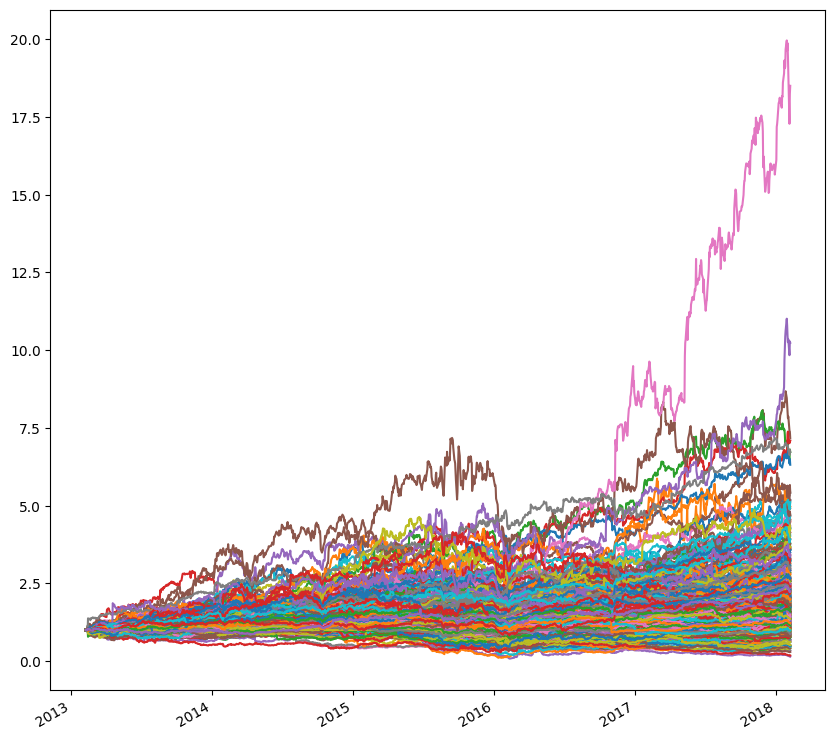

In [ ]:
close_prices_normalized.plot(legend=False, figsize=(10,10));

**OBSERVATION:** We can see the cumulative return of each stock on this normalized plot. This tells us, for example, that if we had invested on that stock that went up to 20, then our investment there would have gone up by a factor of 20. 

In [ ]:
# Let's figure out which stock that was.
close_prices_normalized.gt(19).dot(close_prices_normalized.columns + ',').str[:-1]

2013-02-08        
2013-02-11        
2013-02-12        
2013-02-13        
2013-02-14        
              ... 
2018-02-01    NVDA
2018-02-02        
2018-02-05        
2018-02-06        
2018-02-07        
Length: 1259, dtype: object

**OBSERVATION:** Looks like NVIDIA Corp was the stock with that 20 return on investment.

## Analyze updated dataset
We want to understand if the adjusted close column accounts for stock splits and dividend payments. The data we got from Kaggle didn't have this column but an updated version from Yahoo Financial does.



In [ ]:
# Ensure dates as parsed as dates on the target columns.
df2 = pd.read_csv(f'{data_dir}/sp500sub.csv', index_col='Date', parse_dates=True)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123281 entries, 2018-01-02 to 2023-01-30
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Open       123281 non-null  float64
 1   High       123281 non-null  float64
 2   Low        123281 non-null  float64
 3   Close      123281 non-null  float64
 4   Adj Close  123281 non-null  float64
 5   Volume     123281 non-null  int64  
 6   Name       123281 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 7.5+ MB


In [ ]:
df2.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2018-01-02,95.709999,95.709999,94.239998,95.320000,86.675102,1805700,TEL
2018-01-03,95.419998,97.169998,95.099998,96.930000,88.139091,1812300,TEL
2018-01-04,97.339996,97.919998,96.839996,97.379997,88.548279,1399100,TEL
2018-01-05,98.080002,99.699997,97.839996,99.599998,90.566940,2318300,TEL
2018-01-08,98.809998,99.900002,98.809998,99.809998,90.757889,1609100,TEL


In [ ]:
appl = df2[df2['Name'] == 'AAPL']

In [ ]:
appl

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.888065,102223600,AAPL
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.880951,118071600,AAPL
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.070839,89738400,AAPL
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.538445,94640000,AAPL
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.384159,82271200,AAPL
...,...,...,...,...,...,...,...
2023-01-24,140.309998,143.160004,140.300003,142.529999,142.312714,66435100,AAPL
2023-01-25,140.889999,142.429993,138.809998,141.860001,141.643738,65799300,AAPL
2023-01-26,143.169998,144.250000,141.899994,143.960007,143.740540,54105100,AAPL


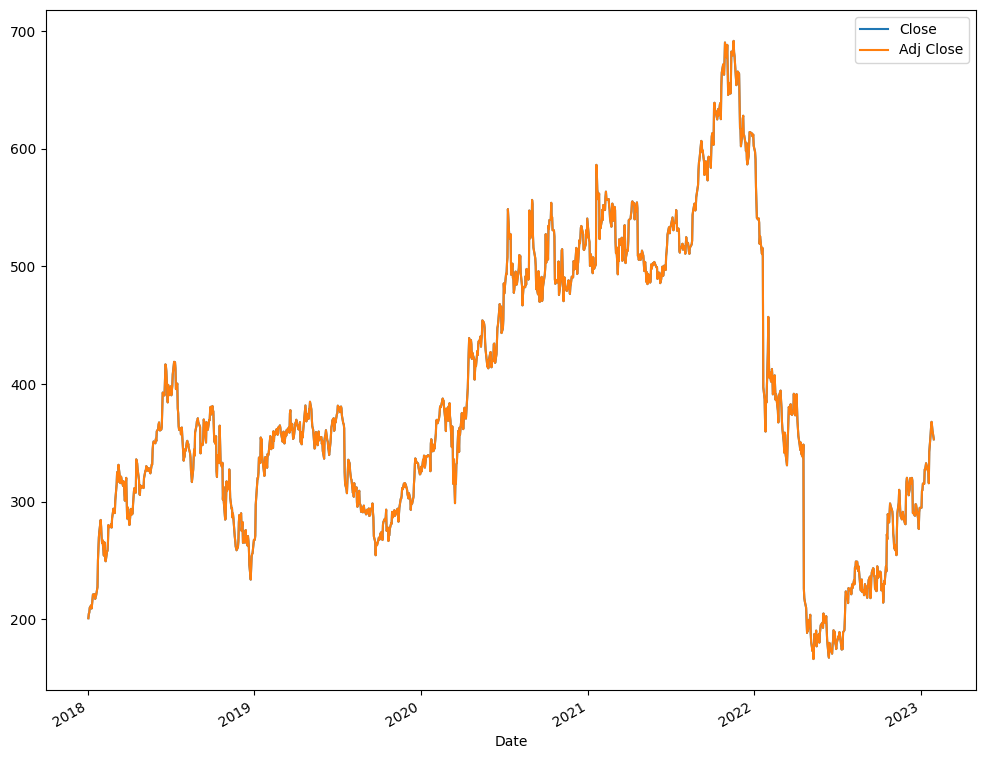

In [ ]:
# Let's collect the close price details for another large company (e.g. Netflix) for illustration purposes.
nflx = df2[df2['Name'] == 'NFLX']
nflx[['Close', 'Adj Close']].plot(figsize=(12,10));

**OBSERVATION:** Both the close and adjusted close prices are the same. We can see on the X-axis in around 2022 then there looks to have been a stock split, this helps very to in this dataset, the non-adjusted close price already accounts for stock splits; hence, why the close and adjusted close are the same.

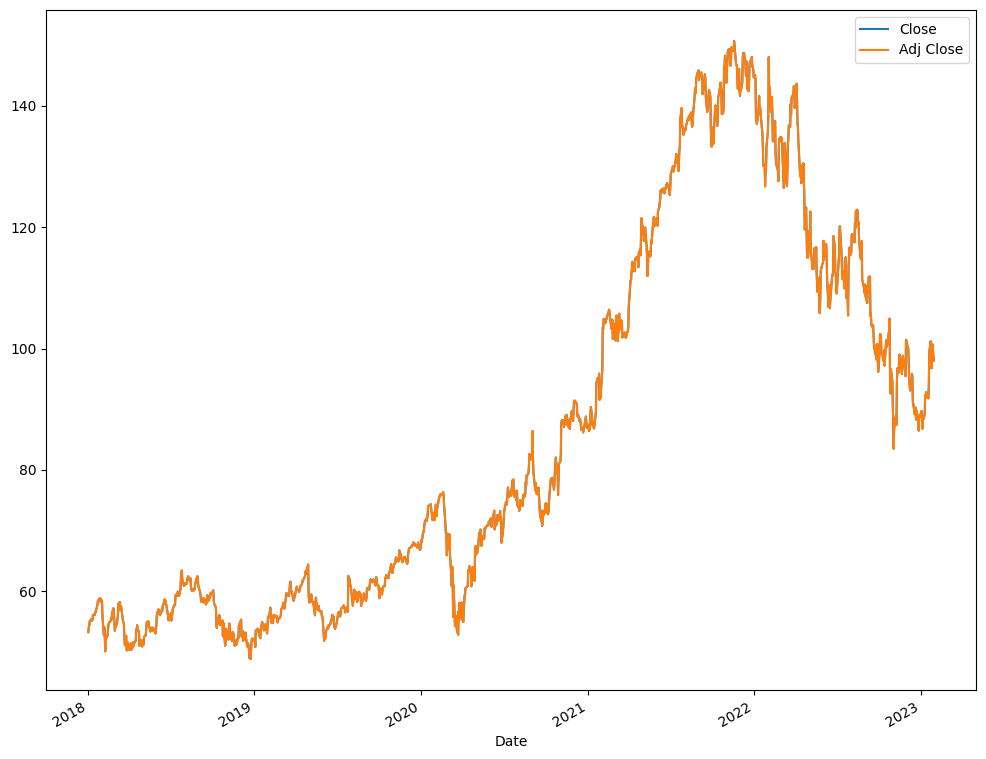

In [ ]:
 # Let's also check Google's stock trends
goog = df2[df2['Name'] == 'GOOG']
goog[['Close', 'Adj Close']].plot(figsize=(12,10));

<Axes: xlabel='Date'>

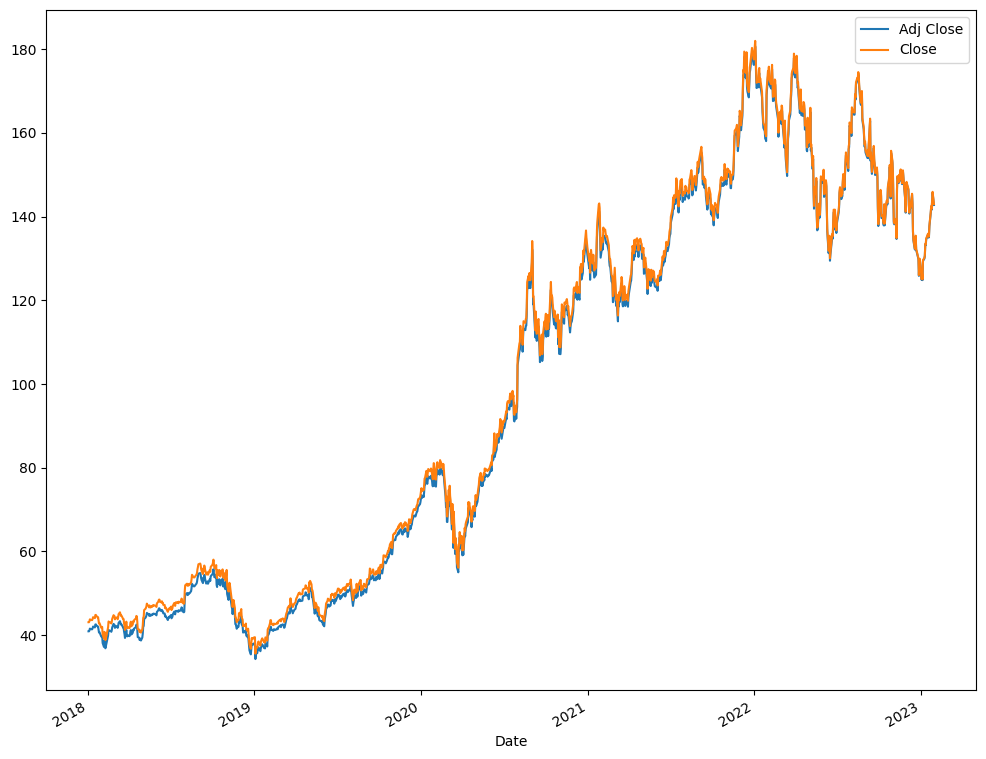

In [ ]:
appl = df2[df2['Name'] == 'AAPL']
appl[['Adj Close','Close']].plot(figsize=(12,10))

**OBSERVATION:** We can observe here that the 'close' and 'adjusted close' prices are not entirely the same. In the most recent trends they are very close but not for the prices between 2018 - 2019. This is clear evidence that the 'adjusted close' price does account for dividends.

### Deeper Financial analysis - Calculating Returns

In [ ]:
# Let's continue the exploration with our 'all_stocks_5yrs" dataset. This time we load it with parse_dates set to True.
df3 = pd.read_csv(f'{data_dir}/all_stocks_5yr.csv', parse_dates=True)

In [ ]:
msft = df3[df3['Name'] == 'MSFT'].copy()
msft.head()

,date,open,high,low,close,volume,Name
390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


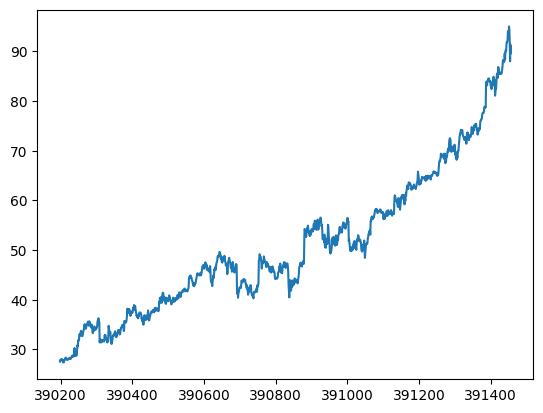

In [ ]:
msft['close'].plot();

To calculate the return we need the current close price as well as the previous close price.

In [ ]:
# To start with store all the items from the close column to a new column called 'prev_close'. 
# The items on this new column are those from the close column shifted by one. Thus, it would
# make sense that the first entry on the 'prev_close' column is 'NaN'.
msft['prev_close'] = msft['close'].shift(1)
msft.head()

,date,open,high,low,close,volume,Name,prev_close
390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT,NaN
390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT,27.55
390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT,27.86
390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT,27.88
390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT,28.03


In [ ]:
# We move on to calculate the return (a vectorized operation).
msft['return'] = msft['close'] / msft['prev_close'] - 1
msft.head()

,date,open,high,low,close,volume,Name,prev_close,return
390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT,NaN,NaN
390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT,27.55,0.011252
390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT,27.86,0.000718
390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT,27.88,0.005380
390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT,28.03,0.000357


**OBSERVATION:** Note the small size of the return amounts. These are very common figures in the realm of financial engineering, commonly using units as basis points.

In [ ]:
# Another method to represent the return is by using the ".pct_change" method; which,
# would yield the same results.
msft['return_as_pct'] = msft['close'].pct_change(1) # argument 1, pct change over one timestep
msft.head()

,date,open,high,low,close,volume,Name,prev_close,return,return_as_pct
390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT,NaN,NaN,NaN
390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT,27.55,0.011252,0.011252
390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT,27.86,0.000718,0.000718
390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT,27.88,0.005380,0.005380
390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT,28.03,0.000357,0.000357


Now that we are looking at the change in return, let's take a closer attention at their distribution on the next trend.

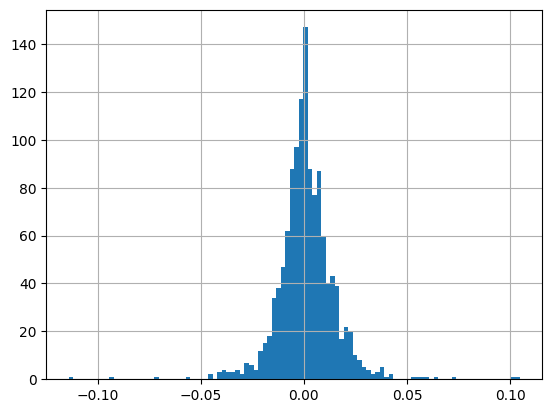

In [ ]:
msft['return'].hist(bins=100);

In [ ]:
# What is the sample mean and sample variance here?
msft['return'].mean(), msft['return'].std() # square root of the variance

(0.0010388741225331477, 0.014210172899610199)

**OBSERVATION:** The return is small, as you can see very close to zero. The standard deviation is also small.

In [ ]:
# Now let's take a look at the log return of this data.
msft['log_return'] = np.log(msft['return'] + 1)
msft.head()

,date,open,high,low,close,volume,Name,prev_close,return,return_as_pct,log_return
390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT,NaN,NaN,NaN,NaN
390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT,27.55,0.011252,0.011252,0.011189
390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT,27.86,0.000718,0.000718,0.000718
390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT,27.88,0.005380,0.005380,0.005366
390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT,28.03,0.000357,0.000357,0.000357


**OBSERVATION:** Log return calculations are very close to the non-log return calculations. The result is by definition small and approximately equal to log of 1 plus x.

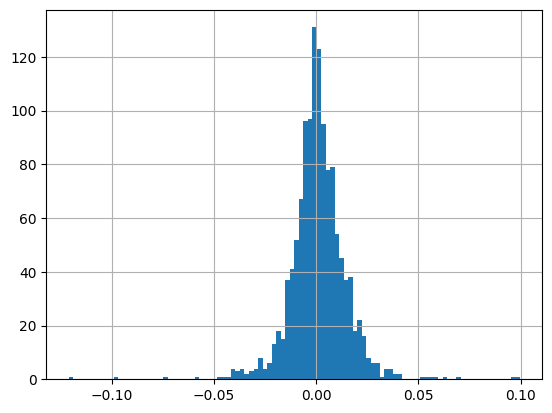

In [ ]:
# Let's plot the distribution
msft['log_return'].hist(bins=100);

**OBSERVATION:** The distribution is very close to the previous one (non-log returns). The trends form a "bell curve" (i.e. Normal/Gaussian distribution). There is a way to check if the data we have sampled actually comes from the normal distribution. We will explore this after the calcuation of the mean & std for the log returns.

In [ ]:
# Let's calculate the sample mean and standard deviation for the log returns.
msft['log_return'].mean(), msft['log_return'].std()

(0.0009375710534953915, 0.014207788068567505)

### Analyzing Probability Plots (a.k.a QQ-Plots)

#### Understanding Normal Distribution

In [ ]:
from scipy.stats import norm

In [ ]:
# List of x-coordinates, expanding from min to max return values in batches of 100.
# We can build this list using np.lispace().
x_list = np.linspace(
    msft['return'].min(),
    msft['return'].max(),
    100)

In [ ]:
# Create the y_list coordinates using the probability density function with our x-coordinate list
# and the mean and standard deviation calculations of our our returns, as arguments.
y_list = norm.pdf(x_list, loc=msft['return'].mean(), scale=msft['return'].std())

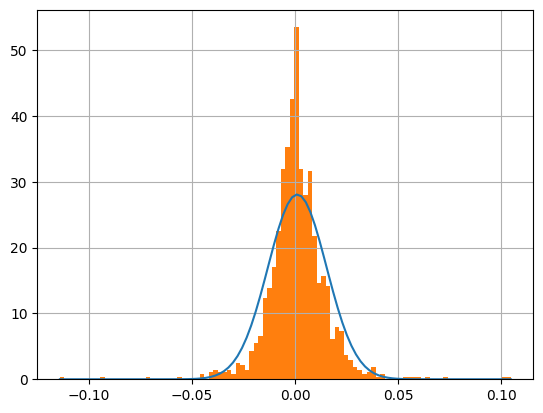

In [ ]:
# Plotting the normal probability density function normalized. 
plt.plot(x_list,y_list);
msft['return'].hist(bins=100, density=True);

**OBSERVATION:** The data's distribution doesn't look compatible for normal distribution. It's close but there are some oddities. The center trends show higher frequency than predicted by the normal distribution. The shoulders show some gaps and the returns show extreme values that may not be likely per the normal distribution.

#### QQ-Plot trends

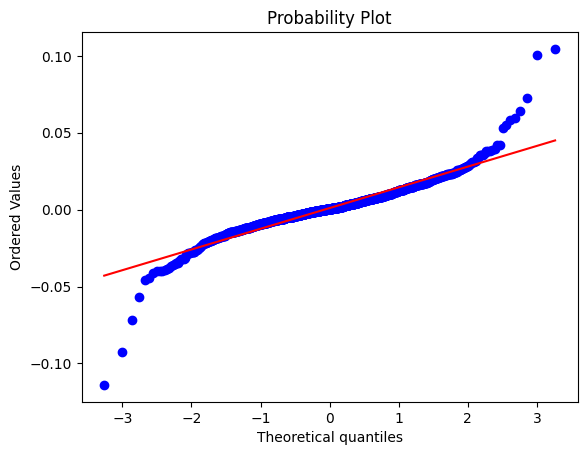

In [ ]:
probplot(msft['return'].dropna(), dist='norm', fit=True, plot=plt);

# Next Steps
- Model evaluation that includes:
  * LinearRegression (auto regressive model)
  * Recursive Neural Network with LSTM
  * Binary classification to attempt to predict stocks up/down trends.
